# VRPPD (Vehicle Routing Problem Pick and Delivering)

En el VRPPD, se tienen varios vehículos que deben visitar un conjunto de ubicaciones para recoger y entregar mercancías. Cada ubicación tiene un conjunto de pedidos que deben ser satisfechos. El objetivo es determinar la ruta óptima para cada vehículo de manera que todos los pedidos sean entregados dentro de un tiempo determinado y minimizando los costos asociados, como la distancia recorrida o el tiempo de viaje. Además, se deben tener en cuenta las restricciones de capacidad de los vehículos para asegurarse de que las mercancías sean entregadas sin exceder la capacidad de carga.


## Método GRASP con soluciones constructivas aleatorias

In [19]:
import random
import pandas as pd
import numpy as np  

def len_sol(lista):
    numeros_distintos = set()

    for tupla in lista:
        numero1, numero2 = tupla
        numeros_distintos.add(numero1)
        numeros_distintos.add(numero2)

    cantidad_distintos = len(numeros_distintos)
    return cantidad_distintos

def construct_solution(V, S, d, q, kappa):
    # Inicializar la solución vacía
    solution = {v: [] for v in V}
    # Inicializar cargas
    loads = []
    passengers_left = q.copy()
    # Construir solución para cada vehículo
    for v in V:
        current_capacity = 0 # Capacidad actual del vehiculo
        current_node = 1  # Comenzar desde el depósito
        # Mientras haya capacidad y nodos disponibles
        while current_capacity < kappa and len_sol(solution[v]) < len(S) - 1:
            
            solution_plane = [valor for tupla in solution[v] for valor in tupla]
            feasible_nodes = [node for node in S if node != current_node and node not in solution_plane and current_capacity + q[node] <= kappa and passengers_left[node] > 0] # Los nodos factibles son los nodos del conjunto S excepto el nodo actual y los que se encuentran en la solución parcial del vehiculo v 
            if len(feasible_nodes) > 0: # Si hay nodos factibles entonces se continua
                # Regla de selección basada en valoración
                # Calcular la función de evaluación para los nodos factibles
                evaluations = [
                    d[current_node-1][node-1]/(passengers_left[node]+0.01) for node in feasible_nodes
                ]
                # Aplicar la regla de selección GRASP para elegir el siguiente nodo
                threshold = min(evaluations) + alpha * (max(evaluations) - min(evaluations))
                candidates = [
                    feasible_nodes[i] for i in range(len(feasible_nodes)) if evaluations[i] <= threshold
                ]
                # Parte aleatoria
                next_node = random.choice(candidates)
                
            else:
                # No hay nodos factibles disponibles, regresar al depósito
                next_node = 1
                break

            # Actualizar la solución parcial y la capacidad acumulada
            if current_capacity + q[next_node] > kappa:
                next_node = 1
            solution[v].append((current_node, next_node))
            current_capacity += passengers_left[next_node]
            passengers_left[next_node] -= q[next_node]
            current_node = next_node
        
        loads.append(current_capacity)
        solution[v].append((current_node, 1))
    return solution,loads

def evaluate_solution(solution, V, d):
    # Calcular la distancia total recorrida en la solución
    total_distance = 0
    total_load = 0
    for v in V:
        route = solution[v]
        for i in range(len(route) - 1):
            inicio, fin = route[i]
            total_distance += d[inicio-1][fin-1]
            total_load += q[inicio] 

    return total_distance, total_load

def local_search(solution, V, d):
    # Implementar una mejora iterativa simple (2-opt) en la solución actual
    improved_solution = solution.copy()
    for v in V:
        route = improved_solution[v]
        for i in range(1, len(route) - 2):
            for j in range(i + 2, len(route)-1):
                # Obtener los nodos involucrados en el intercambio
                node_i = route[i][1]
                node_i_next = route[i+1][1]
                node_j = route[j][1]
                node_j_next = route[j+1][1] if j+1 < len(route) else 1

                # Verificar si el intercambio rompe la coherencia de la ruta
                if node_i != node_j and node_i_next != node_j_next:
                    # Realizar el intercambio 2-opt
                    new_route = route[:i+1] + route[i+1:j][::-1] + route[j:]

                    # Evaluar la nueva ruta y comparar con la ruta actual
                    new_distance, new_load = evaluate_solution({v: new_route for v in V}, V, d)
                    if new_distance < evaluate_solution(improved_solution, V, d)[0] and new_load <= kappa:
                        improved_solution[v] = new_route


    return improved_solution

def grasp(V, S, d, q, kappa, seed):
    random.seed(seed)
    best_solution = None
    best_distance = float('inf')

    for _ in range(max_iterations):
        solution_with_loads = construct_solution(V, S, d, q, kappa)
        solution = local_search(solution_with_loads[0], V, d)
        distance = evaluate_solution(solution, V, d)[0]

        if distance < best_distance:
            best_solution = solution_with_loads
            best_distance = distance

    return best_solution[0], best_distance, best_solution[1]

## Parámetros del problema

In [20]:
# Parámetros de GRASP
alpha = 0.3 # Parámetro de aleatoriedad
max_iterations = 1000  # Número máximo de iteraciones

# Parámetros del problema
d = np.array(pd.read_csv('distance_matrix.csv')) # Distancias entre nodos (i, j)
d = d/1000 # Convertir a KM
q = pd.read_csv('cantidades.txt') # Cantidad de pasajeros en cada nodo
q = q["0"].to_dict()
q = {i + 1: v for i, v in q.items()}

kappa = 60 # Número total de pasajeros en los camiones
num_aut = 4 # Número total de camiones
V = list(range(1, num_aut + 1))  # Conjunto de vehículos
S = list(range(1, len(d) + 1)) # Conjunto de sitios

## Solución

In [21]:
seed = 2023 # Semilla aleatoria

In [22]:
%%time
# Ejecutar GRASP
best_solution, best_distance, total_load = grasp(V, S, d, q, kappa, seed)
print("Mejor distancia total encontrada:", best_distance)

Mejor distancia total encontrada: 54.97319999999999
CPU times: user 130 ms, sys: 1.3 ms, total: 131 ms
Wall time: 131 ms


In [23]:
# Imprimir resultados
print("Mejor distancia total encontrada:", best_distance)
print("Mejor solución encontrada:")
sol = {}
for v in V:
    sol[v] = best_solution[v]
    print("Vehículo", v, ":", best_solution[v])

print("Cargas de cada vehiculo:", total_load)

Mejor distancia total encontrada: 54.97319999999999
Mejor solución encontrada:
Vehículo 1 : [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1)]
Vehículo 2 : [(1, 11), (11, 12), (12, 13), (13, 14), (14, 1)]
Vehículo 3 : [(1, 6), (6, 7), (7, 10), (10, 15), (15, 1)]
Vehículo 4 : [(1, 9), (9, 8), (8, 1)]
Cargas de cada vehiculo: [54, 55, 51, 24]


In [24]:
import json
with open('solution.json', 'a') as f:
    f.write(json.dumps(sol, ensure_ascii = False, indent = 4))

## Grafo generado a partir de la matriz de distancias

De manera aleatoria se generó una matriz de distancia con $n$ sitios a visitar, donde cada sitio tiene $m_i$ personas a recojer con $i \in \{1,2,...,n\}$.

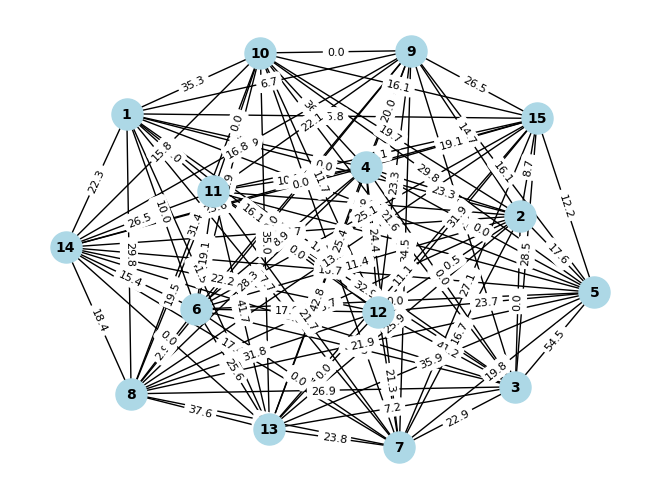

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def graficar_grafo_con_distancias(matriz_distancias):
    # Crear un grafo vacío
    G = nx.Graph()

    # Obtener el tamaño de la matriz
    n = len(matriz_distancias)

    # Agregar nodos al grafo
    G.add_nodes_from(range(1, n+1))

    # Agregar aristas al grafo y asignar las distancias como atributos
    for i in range(n):
        for j in range(i+1, n):
            distancia = matriz_distancias[i][j]
            G.add_edge(i+1, j+1, distancia=distancia)

    # Obtener posiciones para visualizar los nodos
    pos = nx.spring_layout(G)

    # Obtener las distancias como una matriz numpy para la etiqueta de las aristas
    distancias = np.array(matriz_distancias)

    # Dibujar el grafo
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): round(distancias[u-1][v-1], 1) for u, v in G.edges()}, font_size=8)


    # Mostrar el gráfico
    plt.show()


graficar_grafo_con_distancias(d)

In [26]:
def generate_colors(n):
    colors = []
    for _ in range(n):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        color = (r/255, g/255, b/255)
        colors.append(color)
    return colors

## Grafo de direcciones de cada autobús
En el siguiente grafo se colorea cada ruta de tal forma que cada autobús pasa por solo una de ellas, es decir, su camino óptimo obtenido.

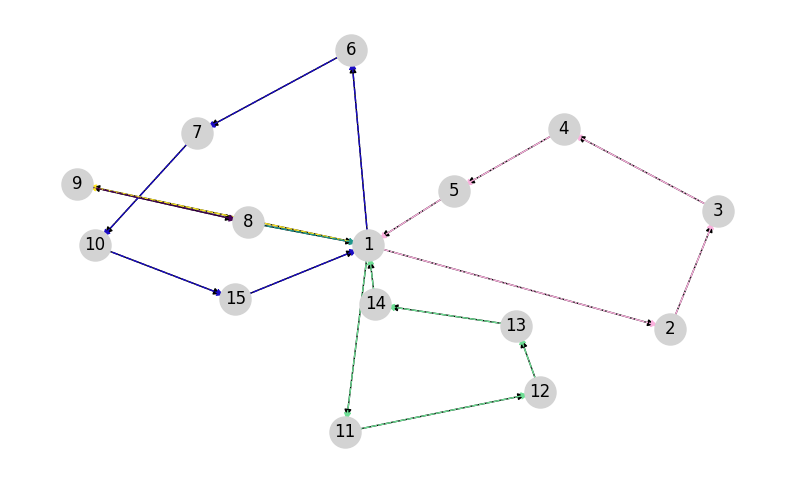

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Crear un grafo dirigido
grafo = nx.DiGraph()

# Agregar las aristas al grafo
for v in V:
    grafo.add_edges_from(best_solution[v])

# Definir el color para todas las aristas
color_list = generate_colors(len(V))
estilo_linea = ['dashed','solid', 'dashed', 'dotted', 'dashdot']

# Dibujar el grafo
pos = nx.spring_layout(grafo)
nx.draw_networkx(grafo, pos, arrows=True, with_labels=True, node_color='lightgray', node_size=500)

# Dibujar las aristas con el mismo color
for v in V:
    nx.draw_networkx_edges(grafo, pos, edgelist=best_solution[v], edge_color=color_list[v-1], arrows=True, style=random.choice(estilo_linea))

# Mostrar el grafo
plt.axis('off')
plt.show()